# Data Wrangling Project Script

This script will cover all data wrangling steps - generating summary statistics, looking for missing data and outliers, and cleaning/transforming data when needed. 

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
import seaborn as sns
#allow all columns to be viewed:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [2]:
#Check current path
current_path = % pwd
#print(current_path)

In [3]:
#If current_path is in Scripts folder, 
#go up one level so we can open the data folder
if (current_path.rsplit('\\', 1)[1] == 'Scripts'):
    % cd ..
    #% pwd

D:\Coding Projects\Springboard\Springboard_Projects\Capstone


## AirBnB Dataset Analysis

### Read in Listings

The AirBnB data comes in multiple files. The I plan to use for this project is listings.csv, which contains detailed information on all of the rentals listed in a city. The data comes from InsideAirBnB (http://insideairbnb.com/about.html#disclaimers) and can be downloaded for specific cities. I have decided to use the city of Toronto, so this version of listings.csv only contains data for Toronto. 

In [4]:
#Read in AirBnB listing data for Toronto
path='../Capstone/Data/listings.csv'
abb_list = pd.read_csv(path)

In [5]:
#View shape of abb_list
abb_list.shape

(17542, 96)

The listings dataset has 17,542 records and 96 columns. 

In [6]:
#View first 5 rows of dataset
abb_list.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20180808031137,2018-08-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",All forms of public transportation are easily ...,The whole house and garden are available.,"We will be out of town, but fully accessible b...",This is our much-loved family home. We expect ...,NaN,NaN,https://a0.muscache.com/im/pictures/76206750/d...,NaN,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Toronto, Ontario, Canada","I live in Toronto, Canada with my husband and ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1565/profile_...,https://a0.muscache.com/im/users/1565/profile_...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",Little Portugal,Little Portugal,NaN,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.646168,-79.424510,f,House,Entire home/apt,10,3.0,5.0,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,$470.00,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,6 months ago,t,0,0,0,0,2018-08-08,7,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.19
1,8077,https://www.airbnb.com/rooms/8077,20180808031137,2018-08-08,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,NaN,NaN,NaN,No smoking please.,NaN,NaN,https://a0.muscache.com/im/pictures/11780344/1...,NaN,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/9a077853-c...,https://a0.muscache.com/im/pictures/9a077853-c...,Harbourfront,2.0,2.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Toronto, ON, Canada",Harbourfront,Waterfront Communities-The Island,NaN,Toronto,ON,M5J,Toronto,"Toronto, Canada",CA,Canada,43.641051,-79.376277,t,Apartment,Private room,2,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$98.00,NaN,"$2,602.00","$2,602.00",NaN,1,$0.00,180,365,15 months ago,t,30,60,90,365,2018-08-08,170,2009-08-20,2013-08-27,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,t,2,1.56
2,103

At first glance I see multiple columns I can drop, and others I would like to analyze further.

 - Columns consisting of URLs - listing_URL, thumbnail_url, medium_url, picture_url, host_url, and approximately three more. I do not plan to analyze any of the pictures at these links and the data I need is already in the dataset so I will drop these columns. Note: I will keep listing_URL in the dataset for now in case I want to inspect a listing directly online. It will not be used for prediction. 
 - Free text and descriptive columns - name, summary, space, description, neighborhood_overview, etc. I have not yet decided if I want to do text analysis on these fields yet. For now I will pull these into a separate dataframe so I can more fully focus on the other fields in the listings dataset. 
 - Scraping information - scrape_id, last_scraped, calendar_last_scraped - I plan to drop scrape_id entirely. For the two "last scraped" fields, at first glance they appear to all have the same value ("2018-08-08") but I will check the unique values to confirm. If they do, I will drop them as well.
 - Redundant location fields:
     -  street: InsideAirBnB masks the exact location, so they fill the street column with "Toronto, ON, Canada". This is not useful and will be dropped.
     -  city, state, zipcode, country_code, country - These are redundant as I am focusing completely on Toronto, and will be dropped.
     -  neighbourhood, neighbourhood_cleansed, neighbourhood_group_cleansed - I probably do not need all three of these columns but I will keep them all for now. I will need to do some research and find out what the difference is between them, and which would be most useful for matching with the Yelp dataset. 
 - Reviews - the goal is to help new hosts determine how much they should charge for their listing. A new host will not have any reviews yet by definition, so we do not need these fields. They will be removed. 

### Drop unnecessary columns

The free text columns will be saved in case I decide to do further analysis on them.

In [7]:
#Move text fields into separate dataframe for now
#Create two lists of variables (text_cols_drop does not include ID so it is kept in the new dataframe)
text_cols_drop = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 
                  'transit', 'access', 'house_rules', 'notes', 'interaction', 'host_about']
text_cols_transfer = text_cols_drop[:]
text_cols_transfer.append('id')
abb_text = abb_list[text_cols_transfer]
abb_text.head(3)

,name,summary,space,description,neighborhood_overview,transit,access,house_rules,notes,interaction,host_about,id
0,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,All forms of public transportation are easily ...,The whole house and garden are available.,This is our much-loved family home. We expect ...,"To learn a little more about our home, see: (U...","We will be out of town, but fully accessible b...","I live in Toronto, Canada with my husband and ...",1419
1,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,NaN,NaN,NaN,No smoking please.,NaN,NaN,My husband and I have been airbnb host for alm...,8077
2,Union Inn II (Leslieville),We offer a private room for two with a queen b...,"The 'union inn' offers a clean, spacious room ...",We offer a private room for two with a queen b...,Our charming adopted home of Leslieville is a ...,Our home is steps from street car and bus acce...,We have high speed wireless internet for your ...,When we travel on airbnb we behave as we would...,"Clean towels, a hair dryer, soap and sanitary ...",We love meeting new people. However we do work...,We are a couple of architects who try to make ...,10314


In [8]:
#Now drop the transferred columns, except ID, from abb_list
abb_list.drop(columns=text_cols_drop, axis=1, inplace=True)
abb_list.shape #confirm columns have been dropped

(17542, 85)

In [9]:
#Drop review columns
review_cols_drop = ['last_review', 'review_scores_rating',
                   'review_scores_accuracy', 'review_scores_cleanliness', 
                   'review_scores_checkin', 'review_scores_communication',
                   'review_scores_location', 'review_scores_value', 'number_of_reviews']
abb_list.drop(columns=review_cols_drop, axis=1, inplace=True)
abb_list.shape

(17542, 76)

### Check for single-value columns

Checking columns that appear to have only one value. If that is true, they can be dropped.

In [10]:
print(abb_list['last_scraped'].value_counts(dropna=False))
print(abb_list['calendar_last_scraped'].value_counts(dropna=False))
print(abb_list['jurisdiction_names'].value_counts(dropna=False))
print(abb_list['host_acceptance_rate'].value_counts(dropna=False))
print(abb_list['requires_license'].value_counts(dropna=False))
print(abb_list['license'].value_counts(dropna=False))
print(abb_list['is_business_travel_ready'].value_counts(dropna=False))
print(abb_list['experiences_offered'].value_counts(dropna=False))

2018-08-08    17542
Name: last_scraped, dtype: int64
2018-08-08    17542
Name: calendar_last_scraped, dtype: int64
NaN    17542
Name: jurisdiction_names, dtype: int64
NaN    17542
Name: host_acceptance_rate, dtype: int64
f    17542
Name: requires_license, dtype: int64
NaN    17542
Name: license, dtype: int64
f    17542
Name: is_business_travel_ready, dtype: int64
none    17542
Name: experiences_offered, dtype: int64


In [11]:
#Drop URL- and location-related columns, and any that seem to have only one value or not useful
#Exception: listing_url in case I want to visually inspect specific listings directly
url_cols = ['thumbnail_url', 'medium_url', 'xl_picture_url', 'picture_url', 
            'host_url', 'host_thumbnail_url', 'host_picture_url']
location_cols = ['street', 'city', 'state', 'zipcode', 'market', 'smart_location', 
                 'country_code', 'country', 'host_location']
other_cols = ['host_id', 'scrape_id', 'last_scraped', 'calendar_last_scraped', 'jurisdiction_names', 
              'host_acceptance_rate', 'requires_license', 'license', 'is_business_travel_ready',
             'first_review', 'host_location', 'host_since', 'host_name', 'host_identity_verified',
             'host_has_profile_pic', 'host_total_listings_count', 'host_listings_count', 
              'experiences_offered', 'calculated_host_listings_count', 'host_verifications',
             'is_location_exact', 'has_availability', 'require_guest_profile_picture', 
              'require_guest_phone_verification']
drop_cols = url_cols + location_cols + other_cols
abb_list.drop(columns=drop_cols, axis=1, inplace=True)
abb_list.shape 

(17542, 37)

In [12]:
abb_list.head()

,id,listing_url,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,NaN,NaN,f,Commercial Drive,Little Portugal,Little Portugal,NaN,43.646168,-79.424510,House,Entire home/apt,10,3.0,5.0,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,$470.00,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,6 months ago,0,0,0,0,f,strict_14_with_grace_period,0.19
1,8077,https://www.airbnb.com/rooms/8077,NaN,NaN,f,Harbourfront,Harbourfront,Waterfront Communities-The Island,NaN,43.641051,-79.376277,Apartment,Private room,2,1.5,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$98.00,NaN,"$2,602.00","$2,602.00",NaN,1,$0.00,180,365,15 months ago,30,60,90,365,f,strict_14_with_grace_period,1.56
2,10314,https://www.airbnb.com/rooms/10314,NaN,NaN,f,Riverdale,Riverdale,South Riverdale,NaN,43.670186,-79.335848,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,""Free parking...",NaN,$69.00,$400.00,"$1,350.00",NaN,NaN,2,$20.00,1,30,11 months ago,0,0,21,296,f,moderate,0.71
3,12604,https://www.airbnb.com/rooms/12604,NaN,NaN,f,The Annex,The Annex,Annex,NaN,43.667241,-79.415978,House,Private room,1,1.5,1.0,1.0,Pull-out Sofa,"{Internet,Wifi,""Pets live on this property"",Ca...",120.0,$65.00,$385.00,$943.00,$130.00,$26.00,1,$20.00,1,10,yesterday,0,0,0,0,f,moderate,NaN
4,17936,https://www.airbnb.com/rooms/17936,within an hour,100%,t,Kensington Market,Kensington Market,Kensington-Chinatown,NaN,43.656400,-79.403295,Apartment,Private room,4,1.0,1.0,2.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",NaN,$99.00,$499.00,"$1,700.00",$300.00,$80.00,1,$20.00,2,1125,4 days ago,5,5,23,23,f,strict_14_with_grace_period,1.18


## Handling Null Values - Checking for Nulls

Next I will check the remaining fields for null values and decide what to do with them.

In [13]:
null_rates = (1 - abb_list.count()/len(abb_list.index)) * 100
print(null_rates[null_rates > 0].sort_values(ascending=False))
print("")
print("Columns with at least one null value: " + str(null_rates[null_rates > 0].count()))

neighbourhood_group_cleansed    100.000000
square_feet                      98.990993
monthly_price                    88.068635
weekly_price                     86.261544
security_deposit                 26.735834
host_response_rate               21.593889
host_response_time               21.593889
cleaning_fee                     18.623874
reviews_per_month                18.395850
host_neighbourhood               13.316612
neighbourhood                     5.016532
beds                              0.085509
bathrooms                         0.085509
bedrooms                          0.028503
host_is_superhost                 0.011401
dtype: float64

Columns with at least one null value: 15


This provides the list of columns with at least one null value. 
 - Many of those have fewer than 1% null values. These will be handled in various ways. Some will be replaced with "Unknown". Others will be replaced with the most common value or the mean of that variable. 
 - neighborhood is important because it will be used to simplify the merge between the AirBnB and Yelp datasets. Therefore I will use K Nearest Neighbors to find the best match, based on latitude and longitude. 
 - neighbourhood_group_cleansed is 100% null, so I will drop that column entirely. 
 - square_feet, monthly_price, and weekly_price are more than 85% null. I plan to drop these columns, but first I will create a flag variable that indicates TRUE if those values existed, FALSE if they were null, because their presence might have some predictive value. 
 - That leaves variables with between 5% and 27% null values. 
     -  security_deposit, cleaning fee - I will assume if these are missing the host does not charge, and will set the values to $0.00
     -  host_response_rate, host_response_time - according to AirBnB's own information (https://www.airbnb.com/help/article/430/what-is-response-rate-and-how-is-it-calculated), these fields calculate how often a host responds to new messages or booking requests within 24 hours, within the last 30 days (or 90 if no messages received within 30 days). AirBnB does not clarify what it means if this value is missing. I will assume the host has not received a message within 90 days and replace the host_response_rate with 0%, and host_response_time with whatever the most common value is. 
     -  reviews_per_month - I am not planning to predict anything with this variable, but it can be used to estimate how often a listing is booked. If the value is missing I will replace with 0, which assumes they do not have any reviews.
     - Others will be replaced with the mode, or most common value. 
     -  Beds, bedrooms, bathrooms - these have relatively low numbers of missing values so I will remove the missing records.

### Handling Null Values - Variables with > 85% missing values

In [14]:
#Drop neighbourhood_group_cleansed as it is 100% missing
abb_list.drop(columns='neighbourhood_group_cleansed', axis=1, inplace=True)

In [15]:
#This function will handle dropping and imputing null values
def handle_missing_values(df, col, how=['drop_col', 'drop_row', 'impute'], imp_num_method='mean', imp_with='most_common'):
    '''
    df = dataframe
    col = list of columns to handle
    imp_num_method = the method to impute numeric variables with. Default is mean. 
    imp_text_with = specified value to replace nulls with. If not specified, will
    ... use the most common value for that variable.
    '''
    for x in col:
        #Create flag variables
        df[df[x].name + '_notNA'] = pd.notna(df[x])

        if how == 'drop_col':
        #if how == 'drop_col', simply drop the column
            df.drop(columns=x, axis=1, inplace=True)
        elif how == 'drop_row':
        #if how == 'drop_row', drop any record where that variable is missing
            df.dropna(axis=0, subset=[x], inplace=True)
        elif how == 'impute':
        #if how == 'impute', impute the value using the method specified
            if df[x].dtype == float or df[x].dtype == int:
            #if numeric, use the specified method (mean is default)
                if imp_num_method == 'mean':
                    df[x].fillna(df[x].mean()[0], inplace=True)
                elif imp_num_method == 'median':
                    df[x].fillna(df[x].median()[0], inplace=True)
                elif imp_num_method == 'mode':
                    df[x].fillna(df[x].mode()[0], inplace=True)
                elif imp_num_method == 'max':
                    df[x].fillna(df[x].max[0], inplace=True)
                elif imp_num_method == 'min':
                    df[x].fillna(df[x].min[0], inplace=True)
                elif imp_num_method == 'zero':
                    df[x].fillna(0.0, inplace=True)
            elif df[x].dtype == 'object':
            #if categorical (object) 
                if imp_with == 'most_common':
                    df[x].fillna(df[x].value_counts().index[0], inplace=True)
                else:
                    df[x].fillna(imp_with, inplace=True)

    return(df)

### Handling Null Values - Dropping Columns

In [16]:
#square_feet, monthly_price, and weekly_price will be dropped but a flag will be created
cols = ['square_feet', 'monthly_price', 'weekly_price']
abb_list = handle_missing_values(abb_list, cols, how='drop_col')

### Handling Null Values - Dropping Records

In [17]:
#beds, bathrooms, bedrooms have low numbers of missing values so we will drop these records
cols = ['bathrooms', 'beds', 'bedrooms']
abb_list = handle_missing_values(abb_list, cols, how='drop_row')

### Handling Null Values - Replacing with Zero

I would like to replace nulls with 0 in security_deposit, cleaning_fee, host_response_rate, but because they have symbols like "$", ",", and "%" Python imported them as text fields. I need to convert them to numeric variables, which requires removing those symbols.

In [18]:
#Next need to remove the $, ',', and % symbols to convert certain fields to numeric. 
cols = ['security_deposit', 'cleaning_fee', 'price', 'extra_people', 'host_response_rate']
abb_list[cols] = abb_list[cols].replace('[\$,%]', '', regex=True).astype(float)
abb_list[cols].dtypes

security_deposit      float64
cleaning_fee          float64
price                 float64
extra_people          float64
host_response_rate    float64
dtype: object

In [19]:
#Replace nulls with 0
cols = ['security_deposit', 'cleaning_fee', 'host_response_rate', 'reviews_per_month']
abb_list = handle_missing_values(abb_list, cols, how='impute', imp_num_method='zero')

### Handling Null Values - Replacing with "Unknown"

In [20]:
#Replace nulls with "Unknown" where appropriate
cols = ['neighbourhood', 'host_neighbourhood', 'neighbourhood_cleansed']
abb_list = handle_missing_values(abb_list, cols, how='impute', imp_with='Unknown')

### Handling Null Values - Replacing with Most Common Value

In [21]:
cols = ['host_response_time', 'host_is_superhost']
abb_list = handle_missing_values(abb_list, cols, how='impute', imp_num_method='mode')

One final check for null values to make sure they are all taken care of.

In [22]:
null_rates = (1 - abb_list.count()/len(abb_list.index)) * 100
print(null_rates[null_rates > 0].sort_values(ascending=False))
print("")
print("Columns with at least one null value: " + str(null_rates[null_rates > 0].count()))

Series([], dtype: float64)

Columns with at least one null value: 0


### Checking for Outliers - View Summary Statistics

Now that missing values have been removed, I can check for outliers in the data. I will start by inspecting the numeric variables and looking for those with a significant difference between the mean and median. This usually means an outlier is pulling the mean away from the median. I will also inspect the gap between the Min and 1st/10th percentiles, and the Max and 90th/99th percentiles, as these can also make outliers apparent. 

In [23]:
abb_list.describe(percentiles=[.01, .1, .5, .9, .99])

,id,host_response_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,reviews_per_month
count,1.751400e+04,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000,1.751400e+04,17514.000000,17514.000000,17514.000000,17514.000000,17514.000000
mean,1.684900e+07,74.435423,43.678617,-79.397257,3.075939,1.235954,1.308610,1.662727,141.221080,239.973164,46.251627,1.637775,13.937364,6.144399,1.812072e+05,6.924061,18.201325,32.660786,124.492634,1.593657
std,7.568580e+06,41.066335,0.047148,0.060703,1.952602,0.539809,0.848582,1.076971,248.847508,381.657421,48.375138,1.264804,23.518891,25.722322,1.789982e+07,8.903657,19.522312,31.200230,128.226009,2.077659
min,1.419000e+03,0.000000,43.586713,-79.624535,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
1%,5.652038e+05,0.000000,43.613438,-79.563235,1.000000,1.000000,0.000000,1.000000,25.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
10%,5.415133e+06,0.000000,43.640200,-79.462765,1.000000,1.000000,1.000000,1.000000,43.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.848936e+07,100.000000,43.661876,-79.397739,2.000000,1.000000,1.000000,1.000000,100.000000,150.000000,39.000000,1.000000,7.000000,2.000000,1.125000e+03,3.000000,11.000000,27.000000,75.000000,0.790000
90%,2.610811e+07,100.000000,43.766546,-79.323881,6.000000,2.000000,2.000000,3.000000,250.000000,500.000000,100.000000,3.000000,35.000000,7.000000,1.125000e+03,23.000000,50.000000,80.000000,338.000000,4.500000
99%,2.746102e+07,100.000000,43.808485,-79.212191,10.000000,3.500000,4.000000,6.000000,699.000000,1999.000000,200.000000,6.000000,100.000000,90.000000,1.125000e+03,30.000000,60.000000,90.000000,365.000000,9.017400
max,2.758201e+07,100.000000,43.847487,-79.127812,16.000000,8.000000,12.000000,16.000000,13010.000000,6505.000000,1000.000000,16.000000,546.000000,1125.000000,2.147484e+09,30.000000,60.000000,90.000000,365.000000,16.860000


From a rough visual inspection of the summary statistics I can see a number of variables that seem to contain outliers:

 -  accommodates: the median is 2, the 90th percentile is 6, and the max is 16. For this variable I plan to trim to the 99th percentile, 10, and turn that into the max. 
 -  bathrooms, bedrooms, beds: these all have significant differences between the 90th percentile and the max. I will trim these to the 99th percentile.
 -  price: I see potential outliers at both ends of the spectrum. There is obviously at least one extreme outlier on the high end of price at \$13,010, where the 90th percentile is 250. I will inspect all records higher than the 90th percentile and decide whether I should trim them to the 90th or 99th percentiles, or remove those records entirely. I also plan to inspect records with $0 price as this seems inaccurate. These will likely be removed from the dataset. 
 -  security_deposit, cleaning fee: similar to price these seem influenced by outliers at the high and low ends. I will inspect these further. It also might be worthwhile to combine price, security_deposit, and cleaning_fee into one "total_price" variable.
 -  guests_included, extra_people: contain outliers at the high end. I will likely trim these to the 90th or 99th percentile, but the outliers might also be removed if I get rid of the price outlier record(s). 
 -  minimum_nights, maximum_nights: these also appear to have outliers at the high end. I will likely trim them to the 99th percentile. I am also not sure if maximum_nights has much value to my analysis as even the median is in the thousands. I will inspect it further.
 -  reviews_per_month: I am keeping this merely to help estimate the true availability of a listing, after which it will be dropped and not used for modeling. So while it appears to have outliers I will not modify this variable.

## Inspecting outliers - Price

Inspect records where price is less than the 10th percentile and greater than the 90th percentile

In [24]:
abb_list[(abb_list['price'] < abb_list['price'].quantile(0.01)) | 
         (abb_list['price'] > abb_list['price'].quantile(0.99))].sort_values(by='price')

,id,listing_url,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,reviews_per_month,square_feet_notNA,monthly_price_notNA,weekly_price_notNA,bathrooms_notNA,beds_notNA,bedrooms_notNA,security_deposit_notNA,cleaning_fee_notNA,host_response_rate_notNA,reviews_per_month_notNA,neighbourhood_notNA,host_neighbourhood_notNA,neighbourhood_cleansed_notNA,host_response_time_notNA,host_is_superhost_notNA
10652,20633078,https://www.airbnb.com/rooms/20633078,within an hour,100.0,t,Parkview,Parkview,O'Connor-Parkview,43.698949,-79.300456,Bungalow,Entire home/apt,5,1.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Wifi,""Air conditioning"",Kitchen...",0.0,0.0,100.0,1,0.0,5,1125,4 months ago,0,0,0,0,f,strict_14_with_grace_period,0.27,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
10394,20350463,https://www.airbnb.com/rooms/20350463,within an hour,100.0,f,Scarborough City Centre,Agincourt,Agincourt North,43.813794,-79.272182,House,Private room,1,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,H...",0.0,500.0,0.0,1,20.0,5,30,today,4,24,54,144,t,moderate,1.44,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
10566,20579837,https://www.airbnb.com/rooms/20579837,within an hour,100.0,f,Shoreditch,Dovercourt Park,Dovercourt-Wallace Emerson-Junction,43.666753,-79.431587,Apartment,Entire home/apt,4,1.0,2.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,Wa...",0.0,300.0,75.0,1,0.0,3,10,2 months ago,0,0,0,0,t,strict_14_with_grace_period,0.00,False,False,False,True,True,True,True,True,True,False,True,True,True,True,True
15682,26007670,https://www.airbnb.com/rooms/26007670,within an hour,100.0,f,Unknown,Newtonbrook,Newtonbrook West,43.774775,-79.442429,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,""Air conditioning"",Kitchen,""Free parking o...",0.0,0.0,20.0,1,0.0,1,1125,2 days ago,11,41,71,161,t,moderate,6.38,False,False,False,True,True,True,True,True,True,True,True,False,True,True,True
10752,20715061,https://www.airbnb.com/rooms/20715061,within an hour,100.0,f,Hillcrest Village,Hillcrest Village,Hillcrest Village,43.801872,-79.348272,House,Private room,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Heating,Washer,Dryer,...",0.0,126.0,10.0,2,15.0,1,1125,3 months ago,4,28,58,58,f,moderate,2.46,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
13356,23290788,https://www.airbnb.com/rooms/23290788,within a few hours,70.0,f,Unknown,Downtown Toronto,Waterfront Communities-The Island,43.639076,-79.395293,Apartment,Entire home/apt,5,2.0,2.0,3.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",""Wheelcha...",0.0,0.0,65.0,1,0.0,1,1125,3 weeks ago,17,47,77,352,f,flexible,0.88,False,False,False,True,True,True,False,True,True,True,True,False,True,True,True
10309,20235002,https://www.airbnb.com/rooms/20235002,within an hour,100.0,f,Downtown Toronto,Little Portugal,Little Portugal,43.643497,-79.427565,Condominium,Entire home/apt,2,1.0,1.0,2.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Gym,Elevat...",0.0,500.0,30.0,1,0.0,1,1125,4 months ago,0,0,0,0,t,strict_14_with_grace_period,0.45,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
11428,21254777,https://www.airbnb.com/rooms/21254777,within an hour,100.0,t,Hillcrest Village,Hillcrest Village,Hillcrest Village,43.802003,-79.353652,Apartment,Entire home/apt,2,1.0,1.0,2.0,Real Bed,"{TV,Wifi,Pool,Kitchen,""Free parking on premise...",0.0,400.0,75.0,1,10.0,1,1125,today,8,8,8,70,f,strict_14_with_grace_period,1.36,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
15752,26082499,

Visually inspecting some of the \$0 price records directly on AirBnB's website, none of them are actually listed at $0. Perhaps this was the price at the time the data scraping occurred and the host changed it soon after (maybe these were new listings). I don't trust these prices so I will remove these records (fewer than 10 records altogether). 

Looking at the high-value apartments (\$700 and higher) is interesting. Visually inspecting them on AirBnB I see they are often huge apartments or homes with lots of luxurious features - art, an in-home gym, upscale furniture. But these elements are not readily apparent from the data, where bedrooms, beds, guests are often the same as other residences. I worry these will confuse the model, so I will remove these from the dataset as well (less than 200 records total). 

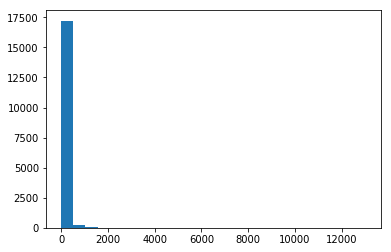

In [25]:
#Histogram of Price before trimming outliers. 
#The majority of values are below $500 but a handful go up to $12,000/night. 
plt.hist(abb_list['price'], bins=25)
plt.show()

## Inspecting Outliers - maximum_nights

In [26]:
abb_list[(abb_list['maximum_nights'] > abb_list['maximum_nights'].quantile(0.9))].sort_values(by='maximum_nights')

,id,listing_url,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,reviews_per_month,square_feet_notNA,monthly_price_notNA,weekly_price_notNA,bathrooms_notNA,beds_notNA,bedrooms_notNA,security_deposit_notNA,cleaning_fee_notNA,host_response_rate_notNA,reviews_per_month_notNA,neighbourhood_notNA,host_neighbourhood_notNA,neighbourhood_cleansed_notNA,host_response_time_notNA,host_is_superhost_notNA
7430,16309682,https://www.airbnb.com/rooms/16309682,within an hour,100.0,t,Oakridge,Pelmo Park,Pelmo Park-Humberlea,43.707794,-79.527059,House,Entire home/apt,8,1.0,3.0,3.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,H...",399.0,500.0,139.0,1,8.0,4,1127,yesterday,6,36,66,341,f,super_strict_30,0.07,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
4742,12273993,https://www.airbnb.com/rooms/12273993,within an hour,98.0,f,Entertainment District,Downtown Toronto,Waterfront Communities-The Island,43.641489,-79.395714,Serviced apartment,Entire home/apt,10,4.0,3.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",1076.0,500.0,150.0,6,50.0,1,1137,today,29,58,88,363,f,strict_14_with_grace_period,3.50,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
8423,17992558,https://www.airbnb.com/rooms/17992558,within an hour,0.0,f,Unknown,Bayview Village,Bayview Village,43.775006,-79.388375,Apartment,Entire home/apt,4,1.0,0.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",75.0,0.0,0.0,2,10.0,2,1200,5 months ago,0,0,0,0,f,strict_14_with_grace_period,0.57,False,False,False,True,True,True,False,False,False,True,True,False,True,False,True
225,692262,https://www.airbnb.com/rooms/692262,within a few hours,100.0,f,Fairbank,Unknown,Corso Italia-Davenport,43.677661,-79.443432,House,Entire home/apt,3,2.0,3.0,3.0,Real Bed,"{Internet,Wifi,""Air conditioning"",Kitchen,""Fre...",200.0,300.0,100.0,1,100.0,30,1460,2 weeks ago,0,0,0,160,f,strict_14_with_grace_period,0.00,True,True,True,True,True,True,True,True,True,False,False,True,True,True,True
7339,16172347,https://www.airbnb.com/rooms/16172347,within an hour,100.0,t,Financial District,Downtown Toronto,Church-Yonge Corridor,43.662680,-79.383403,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",105.0,550.0,69.0,1,50.0,1,1500,5 weeks ago,26,56,86,361,t,strict_14_with_grace_period,2.60,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
185,573892,https://www.airbnb.com/rooms/573892,within an hour,100.0,f,Entertainment District,Entertainment District,Waterfront Communities-The Island,43.643172,-79.380439,Condominium,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",""Wheelcha...",169.0,0.0,50.0,2,0.0,1,1825,2 weeks ago,5,17,42,317,f,strict_14_with_grace_period,0.87,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True
11041,20953519,https://www.airbnb.com/rooms/20953519,within an hour,100.0,f,Entertainment District,Entertainment District,Waterfront Communities-The Island,43.642491,-79.380975,Condominium,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Pool,Kitchen,Gym,E...",169.0,0.0,60.0,2,0.0,1,1825,today,13,32,58,303,f,moderate,1.04,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True
352,1033162,https://www.airbnb.com/rooms/1033162,within an hour,100.0,f,Entertainment District,Entertainment District,Waterfront Communities-The Island,43.643742,-79.379163,Condominium,Entire home/apt,2,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",248.0,0.0,60.

Looking at the high values for maximum_nights, some of them seem nonsensical ('999999999', '2147483647', for example). I am not sure how this field is collected but I don't believe it would have much predictive power so I will remove it completely. 

In [27]:
abb_list.drop(columns='maximum_nights', axis=1, inplace=True)

In [28]:
#Drop records with price, security deposit, cleaning fee outliers 
#... (defined as outside 3 standard deviations from mean)
abb_list = abb_list[np.abs(abb_list['price'] - abb_list['price'].mean()) 
                    <= (3 * abb_list['price'].std())]

abb_list = abb_list[np.abs(abb_list['security_deposit'] - abb_list['security_deposit'].mean()) 
                    <= (3 * abb_list['security_deposit'].std())]

abb_list = abb_list[np.abs(abb_list['cleaning_fee'] - abb_list['cleaning_fee'].mean()) 
                    <= (3 * abb_list['cleaning_fee'].std())]


In [29]:
#Ensure records where price is $0 are dropped
abb_list = abb_list[abb_list['price'] > 0]

In [30]:
abb_list.describe(percentiles=[.01, .1, .5, .9, .99])

,id,host_response_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,reviews_per_month
count,1.693900e+04,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000
mean,1.683628e+07,74.383080,43.678793,-79.397164,2.978511,1.205532,1.262353,1.610130,124.958321,201.954602,42.211524,1.590413,13.439636,5.890430,6.770825,17.911624,32.264124,122.793967,1.612130
std,7.556791e+06,41.116745,0.047304,0.060958,1.783046,0.475904,0.769216,0.975715,94.081663,237.314817,37.907915,1.148967,22.029927,25.154111,8.790641,19.363656,31.024050,127.515335,2.090414
min,1.419000e+03,0.000000,43.586713,-79.624535,1.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,5.722118e+05,0.000000,43.613276,-79.564498,1.000000,1.000000,0.000000,1.000000,25.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,5.434125e+06,0.000000,43.640173,-79.462812,1.000000,1.000000,1.000000,1.000000,42.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.845894e+07,100.000000,43.661969,-79.397737,2.000000,1.000000,1.000000,1.000000,100.000000,150.000000,35.000000,1.000000,6.000000,2.000000,3.000000,10.000000,26.000000,72.000000,0.800000
90%,2.610822e+07,100.000000,43.766864,-79.322886,5.000000,2.000000,2.000000,3.000000,239.000000,500.000000,99.000000,3.000000,35.000000,7.000000,22.000000,50.000000,79.000000,336.200000,4.540000
99%,2.746201e+07,100.000000,43.808720,-79.211849,9.000000,3.000000,4.000000,5.000000,500.000000,1000.000000,150.000000,6.000000,100.000000,90.000000,30.000000,60.000000,90.000000,365.000000,9.090000
max,2.758201e+07,100.000000,43.847487,-79.127812,16.000000,6.500000,8.000000,16.000000,850.000000,1301.000000,170.000000,16.000000,392.000000,1125.000000,30.000000,60.000000,90.000000,365.000000,16.860000


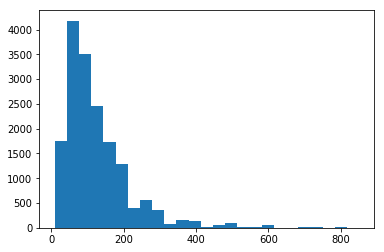

In [31]:
#Histogram of Price after trimming outliers. 
plt.hist(abb_list['price'], bins=25)
plt.show()

## Handling Outliers Functionally

In [32]:
def winsorize_outliers(data):
    
    quantiles = data.quantile([0.05, 0.95])
    q_05 = quantiles.loc[0.05]
    q_95 = quantiles.loc[0.95]

    out = np.where(data.values <= q_05, q_05,
                   np.where(data >= q_95, q_95, data))
    
    return out

In [33]:
#Trim accomodates, bathrooms, bedrooms, beds, guests_included, extra_people, minimum_nights to the 99th percentiles
cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'extra_people', 'minimum_nights']
abb_list[cols] = abb_list[cols].apply(winsorize_outliers)

In [34]:
abb_list.describe(percentiles=[.01, .1, .5, .9, .99])

,id,host_response_rate,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,availability_30,availability_60,availability_90,availability_365,reviews_per_month
count,1.693900e+04,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000,16939.000000
mean,1.683628e+07,74.383080,43.678793,-79.397164,2.878918,1.178169,1.239093,1.582148,124.958321,201.954602,42.211524,1.529665,12.163882,3.700691,6.770825,17.911624,32.264124,122.793967,1.612130
std,7.556791e+06,41.116745,0.047304,0.060958,1.475759,0.362380,0.687578,0.850026,94.081663,237.314817,37.907915,0.901444,15.233044,5.567862,8.790641,19.363656,31.024050,127.515335,2.090414
min,1.419000e+03,0.000000,43.586713,-79.624535,1.000000,1.000000,0.000000,1.000000,10.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1%,5.722118e+05,0.000000,43.613276,-79.564498,1.000000,1.000000,0.000000,1.000000,25.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10%,5.434125e+06,0.000000,43.640173,-79.462812,1.000000,1.000000,1.000000,1.000000,42.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.845894e+07,100.000000,43.661969,-79.397737,2.000000,1.000000,1.000000,1.000000,100.000000,150.000000,35.000000,1.000000,6.000000,2.000000,3.000000,10.000000,26.000000,72.000000,0.800000
90%,2.610822e+07,100.000000,43.766864,-79.322886,5.000000,2.000000,2.000000,3.000000,239.000000,500.000000,99.000000,3.000000,35.000000,7.000000,22.000000,50.000000,79.000000,336.200000,4.540000
99%,2.746201e+07,100.000000,43.808720,-79.211849,6.000000,2.000000,3.000000,4.000000,500.000000,1000.000000,150.000000,4.000000,50.000000,25.000000,30.000000,60.000000,90.000000,365.000000,9.090000
max,2.758201e+07,100.000000,43.847487,-79.127812,6.000000,2.000000,3.000000,4.000000,850.000000,1301.000000,170.000000,4.000000,50.000000,25.000000,30.000000,60.000000,90.000000,365.000000,16.860000


## Unpack "Amenities" variable into flags

The amenities variable is stored as a nested dictionary with multiple values packed together. I would like to use this variable by unpacking it into multiple flag variables. 

In [35]:
#Inspect amenities
abb_list['amenities'][0:5]

0    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
2    {Wifi,"Air conditioning",Kitchen,"Free parking...
3    {Internet,Wifi,"Pets live on this property",Ca...
4    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
5    {Internet,Wifi,"Air conditioning",Kitchen,"Fre...
Name: amenities, dtype: object

In [154]:
#unpack and clean up amenities into a pandas Series
amenities = []
for x in abb_list['amenities']:
    amenities.extend(str.split(x, sep=','))    #Split on commas, append to amenities list


amenities = pd.Series(amenities)              #Convert to Series so str.replace works
amenities = amenities.str.replace('[{}]', '') #Remove brackets '{' and '}'

In [156]:
#Convert to series of value_counts, for inspection and later re-use
amenities = amenities.value_counts()
amenities

Wifi                                  16537
Heating                               16201
Essentials                            15960
Kitchen                               15653
"Smoke detector"                      15609
"Air conditioning"                    14145
Hangers                               13792
Washer                                13622
Dryer                                 13362
Shampoo                               13043
"Carbon monoxide detector"            12761
"Laptop friendly workspace"           12244
TV                                    11700
"Hair dryer"                          11684
Iron                                  11212
"Hot water"                            8696
"Fire extinguisher"                    8265
"Family/kid friendly"                  7354
Elevator                               7052
"Free parking on premises"             6796
"First aid kit"                        6165
Refrigerator                           5754
Internet                        

In [306]:
def unpack_amenities(df, column):
    for index, amenity in amenities.iteritems():
        word = index
        word = word.replace('/', '')    #Replace slash with underscore
        word = word.replace(' ', '_')   #Replace space with underscore
        word = word.replace('"', '')    #Remove quotation marks
        
        for index2, value in df[[column]].iterrows():
            df.loc[index2, 'has_' + word] = (index in str(value))

    return df

#might be faster if you turn each amenity value into a list first and search through that,
#insead of searching the whole string

#Or within a for loop, do a lambda function that checks within the list

In [307]:
abb_list_copy = abb_list.copy()

In [308]:
abb_list_copy = unpack_amenities(abb_list_copy, 'amenities')

In [309]:
abb_list_copy.head()

,id,listing_url,host_response_time,host_response_rate,host_is_superhost,host_neighbourhood,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,instant_bookable,cancellation_policy,reviews_per_month,square_feet_notNA,monthly_price_notNA,weekly_price_notNA,bathrooms_notNA,beds_notNA,bedrooms_notNA,security_deposit_notNA,cleaning_fee_notNA,host_response_rate_notNA,reviews_per_month_notNA,neighbourhood_notNA,host_neighbourhood_notNA,neighbourhood_cleansed_notNA,host_response_time_notNA,host_is_superhost_notNA,has_Wifi,has_Heating,has_Essentials,has_Kitchen,has_Smoke_detector,has_Air_conditioning,has_Hangers,has_Washer,has_Dryer,has_Shampoo,has_Carbon_monoxide_detector,has_Laptop_friendly_workspace,has_TV,has_Hair_dryer,has_Iron,has_Hot_water,has_Fire_extinguisher,has_Familykid_friendly,has_Elevator,has_Free_parking_on_premises,has_First_aid_kit,has_Refrigerator,has_Internet,has_Dishes_and_silverware,has_Gym,has_Microwave,has_Stove,has_Self_check-in,has_Oven,has_Bed_linens,has_Cooking_basics,has_Lock_on_bedroom_door,has_Long_term_stays_allowed,has_Private_entrance,has_Coffee_maker,has_Cable_TV,has_Step-free_access,has_Extra_pillows_and_blankets,has_Dishwasher,has_translation_missing:_en.hosting_amenity_50,has_Paid_parking_off_premises,has_Pool,has_Luggage_dropoff_allowed,has_Patio_or_balcony,has_Safety_card,has_translation_missing:_en.hosting_amenity_49,has_Hot_tub,has_Host_greets_you,has_Lockbox,has_24-hour_check-in,has_Pets_allowed,has_Private_living_room,has_Paid_parking_on_premises,has_Breakfast,has_Bathtub,has_Wide_doorway,has_Buzzerwireless_intercom,has_Garden_or_backyard,has_Indoor_fireplace,has_Keypad,has_Free_street_parking,has_Other,has_Wheelchair_accessible,has_Doorman,has_Pets_live_on_this_property,has_Well-lit_path_to_entrance,has_BBQ_grill,has_Ethernet_connection,has_Single_level_home,has_Wide_hallway_clearance,has_Room-darkening_shades,has_Flat_path_to_front_door,has_Smoking_allowed,has_Children’s_books_and_toys,has_Wide_clearance_to_bed,has_Building_staff,has_Smart_lock,has_Wide_entryway,has_High_chair,has_Cleaning_before_checkout,has_Pack_’n_Playtravel_crib,has_Dog(s),has_Accessible-height_bed,has_Cat(s),has_Suitable_for_events,has_Accessible-height_toilet,has_Lake_access,has_Waterfront,has_Crib,has_Handheld_shower_head,has_Children’s_dinnerware,has_Disabled_parking_spot,has_Game_console,has__toilet,has_Wide_clearance_to_shower,has_Pocket_wifi,has_Babysitter_recommendations,has_Full_kitchen,has_Outlet_covers,has_Stair_gates,has_Baby_bath,has_Hot_water_kettle,has_Window_guards,has_Bathroom_essentials,has_Bedroom_comforts,has_Changing_table,has_Toilet_paper,has_Bath_towel,has_Body_soap,has_EV_charger,has_Beachfront,has_Fireplace_guards,has_Netflix,has_Other_pet(s),has_Roll-in_shower,has_,has_Beach_essentials,has_Smart_TV,has_Baby_monitor,has_Fixed_grab_bars_for_shower,has_Breakfast_table,has_Walk-in_shower,has_Convection_oven,has_Outdoor_seating,has_Sound_system,has_Bathtub_with_bath_chair,has_Rain_shower,has_Balcony,has_Pillow-top_mattress,has_Table_corner_guards,has_Soaking_tub,has_Formal_dining_area,has_En_suite_bathroom,has_Memory_foam_mattress,has_Terrace,has_Central_air_conditioning,has_Shower_chair,has_Espresso_machine,has_Firm_mattress,has_Gas_oven,has_Ceiling_fan,has_Heated_floors,has_Fixed_grab_bars_for_toilet,has_DVD_player,has_Exercise_equipment,has_Printer,has_Outdoor_parking,has_Private_bathroom,has_Shared_gym,has_Day_bed,has_HBO_GO,has_Kitchenette,has_Murphy_bed,has_Amazon_Echo,has_Shared_pool,has_Warming_drawer,has_Ski_inSki_out,has_Fire_pit,has_Mini_fridge,has_Pool_with_pool_hoist,has_Sauna,has_Heated_towel_rack,has_Electric_profiling_bed,has_High-resolution_computer_monitor,has_Wine_cooler,has_Air_purifier,has_Ground_floor_access,has_Shared_hot_tub,has_Jette

In [311]:
abb_list_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16939 entries, 0 to 17541
Columns: 232 entries, id to has_Steam_oven
dtypes: bool(200), float64(14), int64(5), object(13)
memory usage: 8.1+ MB


In [310]:
#Check shape, make sure it matches expectations
abb_list_copy.shape

(16939, 232)

There were 185 amenities. The original abb_list dataframe had 47 columns, so I expected to see 232 columns in the new dataframe, which is what the new dataframe (abb_list_copy) shows.

## Saving cleaned file for easy access

In [314]:
abb_list_copy.to_csv('../Capstone/Data/listings_clean.csv', index=False)

Now that nulls and outliers have been taken care of in the AirBnB dataset, it is time to turn my attention to the Yelp dataset, which thankfully has fewer variables in need of wrangling. 

# Yelp Dataset Analysis

## Read in Data

Next I will open the Yelp dataset. This data comes from Yelp's Academic dataset, found here: https://www.yelp.com/dataset. The data is made available by Yelp in JSON format. I plan to use this dataset to find the average review rating and number of businesses of various types in the vicinity of Toronto AirBnB listings. 

In [196]:
#Read in Yelp Business dataset
path='../Capstone/Data/yelp_academic_dataset_business.json'
yelp_df = pd.read_json(path, lines=True, encoding='utf-8')

In [197]:
print(yelp_df.shape)
print("")
print(yelp_df.info())

(188593, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188593 entries, 0 to 188592
Data columns (total 15 columns):
address         188593 non-null object
attributes      162807 non-null object
business_id     188593 non-null object
categories      188052 non-null object
city            188593 non-null object
hours           143791 non-null object
is_open         188593 non-null int64
latitude        188587 non-null float64
longitude       188587 non-null float64
name            188593 non-null object
neighborhood    188593 non-null object
postal_code     188593 non-null object
review_count    188593 non-null int64
stars           188593 non-null float64
state           188593 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 21.6+ MB
None


The Yelp dataset has 188,593 rows and 15 columns. 

In [198]:
yelp_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",Montréal,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB


## Inspect Cities and Narrow to Toronto

I can see there are multiple cities in this dataset. I only care about Toronto, so before doing any further analysis I plan to limit the dataset. First I will check and confirm Toronto is actually in the data.

In [199]:
yelp_df['city-state'] = yelp_df['city']+'-'+yelp_df['state']

In [200]:
yelp_df['city-state'].value_counts()

Las Vegas-NV                        28853
Phoenix-AZ                          18561
Toronto-ON                          18231
Charlotte-NC                         9203
Scottsdale-AZ                        8822
Calgary-AB                           7383
Pittsburgh-PA                        6802
Mesa-AZ                              6238
Montréal-QC                          6045
Henderson-NV                         4813
Tempe-AZ                             4491
Chandler-AZ                          4271
Cleveland-OH                         3506
Glendale-AZ                          3469
Madison-WI                           3415
Gilbert-AZ                           3397
Mississauga-ON                       2954
Peoria-AZ                            1868
Markham-ON                           1699
North Las Vegas-NV                   1507
Champaign-IL                         1243
North York-ON                        1139
Surprise-AZ                          1119
Scarborough-ON                    

There are too many cities to view this way, instead I will look for the top 10 cities in the dataset

In [201]:
city_count = yelp_df['city'].value_counts().to_frame().reset_index().sort_values('city', ascending=False)
city_count.head(10)

,index,city
0,Las Vegas,28865
1,Phoenix,18633
2,Toronto,18233
3,Charlotte,9204
4,Scottsdale,8822
5,Calgary,7384
6,Pittsburgh,6804
7,Mesa,6239
8,Montréal,6045
9,Henderson,4815


Toronto appears to be the third largest city in the dataset in terms of number of businesses and should give me plenty of data to work with. Next I will limit the dataset by filtering out all other cities. However I know that my AirBnB data includes listings for smaller towns just outside of Toronto, so I will filter on 'state' == 'ON'.

In [202]:
yelp_df = yelp_df[yelp_df['state'] == 'ON']
yelp_df.shape

(32393, 16)

I also know I can limit the results by removing businesses that are no longer open using the is_open variable. If the value is 0 it means the business is closed. Dropping closed businesses leaves me with around 26K records.

In [203]:
yelp_df = yelp_df[yelp_df['is_open'] == 1]
yelp_df.shape

(26031, 16)

## Limit to just restaurants and bars

This dataset has lots of businesses, not just restaurants, but I would like to limit my results to view only the restaurants and bars in a given area. To do this I will need to unpack the categories variable. 

In [204]:
yelp_df['categories'][0:5]

7                                     Restaurants, Thai
23                         Food, Bakeries, Coffee & Tea
28    Optometrists, Shopping, Eyewear & Opticians, H...
42    Home Services, Shopping, Home & Garden, Kitche...
43    Hotels, Hotels & Travel, Event Planning & Serv...
Name: categories, dtype: object

In [207]:
categories = []
for iter in yelp_df['categories']:
    categories.extend(str.split(str(iter), sep=','))

categories = pd.Series(categories)
categories = categories.str.lstrip()
categories.value_counts()

Restaurants                   10405
Food                           5029
Shopping                       4090
Beauty & Spas                  2773
Nightlife                      1758
Bars                           1583
Coffee & Tea                   1501
Health & Medical               1431
Event Planning & Services      1256
Local Services                 1228
Active Life                    1122
Automotive                     1122
Chinese                        1104
Fashion                        1092
Specialty Food                 1011
Hair Salons                     993
Fast Food                       983
Pizza                           961
Sandwiches                      943
Bakeries                        856
Home Services                   844
Breakfast & Brunch              838
Italian                         816
Burgers                         796
Nail Salons                     780
Canadian (New)                  770
Hotels & Travel                 745
Cafes                       

In [283]:
def unpack_categories(df, column):
    for index, value in df[[column]].iterrows():
        df.loc[index, 'is_restaurant'] = ('Restaurants' in str(value)) | ('Food' in str(value))
        df.loc[index, 'is_bar'] = ('Bars' in str(value)) | ('Nightlife' in str(value))
    return df

In [284]:
yelp_df_copy = yelp_df.copy()

In [285]:
yelp_df_copy = unpack_categories(yelp_df_copy, 'categories')

In [296]:
#Drop records that are not a restaurant or bar/nightlife
yelp_df_2 = yelp_df_copy.copy()

yelp_df_2 = yelp_df_2[(yelp_df_2['is_restaurant'] == True) | (yelp_df_2['is_bar'] == True)]

yelp_df_2.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state,city-state,is_restaurant,is_bar
7,"3417 Derry Road E, Unit 103","{'Alcohol': 'none', 'BusinessAcceptsCreditCard...",6OuOZAok8ikONMS_T3EzXg,"Restaurants, Thai",Mississauga,None,1,43.712946,-79.632763,Thai One On,Ridgewood,L4T 1A8,7,2.0,ON,Mississauga-ON,True,False
23,746 Street Clair Avenue W,"{'BikeParking': 'True', 'BusinessAcceptsCredit...",5J3b7j3Fzo9ISjChmoUoUA,"Food, Bakeries, Coffee & Tea",Toronto,"{'Monday': '7:30-19:0', 'Tuesday': '7:30-19:0'...",1,43.681328,-79.427884,Mabel's Bakery,Wychwood,M6C 1B5,23,4.0,ON,Toronto-ON,True,False
53,788 Wilson Avenue,"{'BusinessAcceptsCreditCards': 'False', 'GoodF...",Be7Mwq06nf1eNLblo1ekow,"Bakeries, Food, Latin American, Restaurants, S...",North York,None,1,43.731316,-79.465133,La Rosa Chilena,Downsview,M3K 1E2,5,2.5,ON,North York-ON,True,False
69,273 Bloor Street W,"{'Ambience': '{'romantic': False, 'intimate': ...",RJEtBRLJmmji_QoqS6ysjg,"Music Venues, Arts & Entertainment, Nightlife",Toronto,None,1,43.667749,-79.396167,Royal Conservatory of Music,University of Toronto,M5S 1W2,3,4.5,ON,Toronto-ON,False,True
80,81 Underhill Drive,"{'Alcohol': 'none', 'Ambience': '{'romantic': ...",YIez_A3WOt9J2SXN7OMa2Q,"Caribbean, Food, Bakeries, Restaurants",Toronto,"{'Monday': '11:30-22:0', 'Tuesday': '11:30-22:...",1,43.745928,-79.324623,Allwyn's Bakery,,M3A 1K8,105,4.0,ON,Toronto-ON,True,False


## Drop Uneccessary Columns

Next I will remove columns that I do not plan to use in my analysis. My goal is to end up with the count of businesses and average star rating in a given area. 

To that end I believe I can safely drop address (I have neighborhood and latitude/longitude to join on), attributes, categories, hours, is_open, name, postal_code, and state (I am keeping City for now because it may help when I get ready to merge the Yelp and AirBnB data. 

In [297]:
#Drop unecessary columns
cols = ['attributes', 'address', 'categories', 'hours', 'is_open', 'name', 'postal_code', 'state']
yelp_df_2.drop(columns=cols, axis=1, inplace=True)
yelp_df_2.shape

(13175, 10)

## Check for Null Values

In [298]:
null_rates = (1 - yelp_df_2.count()/len(yelp_df_2.index)) * 100
print(null_rates[null_rates > 0].sort_values(ascending=False))
print("")
print("Columns with at least one null value: " + str(null_rates[null_rates > 0].count()))

Series([], dtype: float64)

Columns with at least one null value: 0


Checking for nulls using the same method I used on the AirBnB dataset finds no missing values. However I remember from inspecting the first few rows that there are some null values, at least in the neighborhood column. 

This leads me to believe there are null values, but possibly encoded with a space so they don't register as nulls. 

In [299]:
yelp_df_2.head()

,business_id,city,latitude,longitude,neighborhood,review_count,stars,city-state,is_restaurant,is_bar
7,6OuOZAok8ikONMS_T3EzXg,Mississauga,43.712946,-79.632763,Ridgewood,7,2.0,Mississauga-ON,True,False
23,5J3b7j3Fzo9ISjChmoUoUA,Toronto,43.681328,-79.427884,Wychwood,23,4.0,Toronto-ON,True,False
53,Be7Mwq06nf1eNLblo1ekow,North York,43.731316,-79.465133,Downsview,5,2.5,North York-ON,True,False
69,RJEtBRLJmmji_QoqS6ysjg,Toronto,43.667749,-79.396167,University of Toronto,3,4.5,Toronto-ON,False,True
80,YIez_A3WOt9J2SXN7OMa2Q,Toronto,43.745928,-79.324623,,105,4.0,Toronto-ON,True,False


In [300]:
print(yelp_df_2['neighborhood'].value_counts(dropna=False).head(10))

                          5320
Scarborough                846
Downtown Core              627
Etobicoke                  585
Milliken                   268
Willowdale                 226
Entertainment District     207
Unionville                 193
Financial District         157
Leslieville                153
Name: neighborhood, dtype: int64


We can see that the most frequent neighborhood value is blank. This is a problem because my plan was to first join this dataset with AirBnB on neighborhood, then look for businesses within a certain radius based on latitude and longitude. With these records I will need to compare lat/long against the entire Yelp dataset, which will be more time-consuming. However I do not want to lose these records, so for now I will keep them and replace the blank with "Unknown". 

In [302]:
yelp_df_2['neighborhood'].replace("", "Unknown", inplace=True)

#Check again and confirm "" has been replaced by "Unknown"
print(yelp_df_2['neighborhood'].value_counts(dropna=False).head(3))

Unknown          5320
Scarborough       846
Downtown Core     627
Name: neighborhood, dtype: int64


Next I will double-check the remaining fields. Business_id is a text field so I will check it's value counts. Ideally no value should have more than 1 count since it is an ID variable. 

In [303]:
print(yelp_df_2['business_id'].value_counts(dropna=False).head())

rPu_VpOCXTfNOmrk5XqeOg    1
pCcSwPDY1EHQMssgLlNbZg    1
y4GgOCMonFP5G1eZEdbcYg    1
9Uh1b4m8vwbcRfKSbye9ng    1
VkC6GKsyrirYtEFlbFPJDQ    1
Name: business_id, dtype: int64


Finally I will check the numeric variables using the describe() method. This also shows no missing values for the remaining fields.

I can also see the only field with outliers is review_count. However I plan to group this variable before using in predictions so I will leave the outliers. 

In [304]:
yelp_df_2.describe()

,latitude,longitude,review_count,stars
count,13175.000000,13175.000000,13175.000000,13175.000000
mean,43.716969,-79.435540,36.101632,3.427666
std,0.142106,0.361030,65.766124,0.793986
min,42.980602,-114.000446,3.000000,1.000000
25%,43.649589,-79.518599,6.000000,3.000000
50%,43.678898,-79.408232,14.000000,3.500000
75%,43.786387,-79.361236,39.000000,4.000000
max,51.008028,-75.659967,1837.000000,5.000000


## Save Cleaned File for Easy Access

In [305]:
yelp_df_2.to_csv('../Capstone/Data/yelp_clean.csv', index=False)